### Results and visualization

@cesans

In [1]:
import sys
sys.path.append('..')
import deep_control as dc

import numpy as np

import pickle

In [2]:
from tqdm import tqdm

In [3]:
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
sns.set_context("talk")
sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})


The previously trained models are loaded with *dc.nn.load_network()*

In [4]:
model_th = dc.nn.load_model('../nets/mass_thrusters/0/ReLu_outputLog_3_128.model')
network_th = dc.nn.load_network(model_th, base_dir='../')

model_th_L = dc.nn.load_model('../nets/mass_thrusters/1/ReLu_outputLog_3_128.model')
network_th_L = dc.nn.load_network(model_th_L, base_dir='../')

model_th_R = dc.nn.load_model('../nets/mass_thrusters/2/ReLu_outputLog_3_128.model')
network_th_R = dc.nn.load_network(model_th_R, base_dir='../')

networks = [(model_th, network_th),
            (model_th_L, network_th_L),
            (model_th_R, network_th_R)]

The training data is loaded with *dc.nn.load_training_data* to compute the error of the training and validation sets

In [5]:
data = dc.nn.load_training_data(model_th, '../')

In [6]:
batch= 1000

for dset in ['train', 'test']:
    
        for i,(model,network) in enumerate(networks):

            error = []    
            for b in tqdm(range(int(data['X_'+dset].shape[0]/batch)), dset + ' set, network ' + str(i) , leave=True):
                u = np.zeros((batch,len(networks)))
                network_input = data['X_'+dset][b*batch:(b+1)*batch,:]
               # network_input = dc.nn.preprocess(model, network_input)
                ui = network['pred'](network_input) 
                u[:,i] = ui[:,0]
                u = dc.nn.postprocess(model, u)
                u_gt = data['Y_'+dset][b*batch:(b+1)*batch,:].copy()        
                u_gt = dc.nn.postprocess(model, u_gt)        
                error.append((np.abs(u[:,i] - u_gt[:,i])).mean())

            print('network {0}, {1} error {2}'.format(i, dset, np.mean(error)))

    

train set, network 1: 100%|██████████| 16790/16790 [00:59<00:00, 281.46it/s]

network 0, train error 83.00133075713299
network 1, train error 6.061123741730116


train set, network 2: 100%|██████████| 16790/16790 [01:00<00:00, 279.32it/s]


network 2, train error 11.890015447888937


test set, network 0: 100%|██████████| 1865/1865 [00:06<00:00, 285.44it/s]


network 0, test error 83.17617347537713


test set, network 1: 100%|██████████| 1865/1865 [00:06<00:00, 278.08it/s]


network 1, test error 6.059374893940903


test set, network 2: 100%|██████████| 1865/1865 [00:06<00:00, 283.22it/s]


network 2, test error 12.034684592181454


In [ ]:
sns.set(font_scale=1.8)

sns.set_style("whitegrid")
#sns.set_context("talk")
sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})


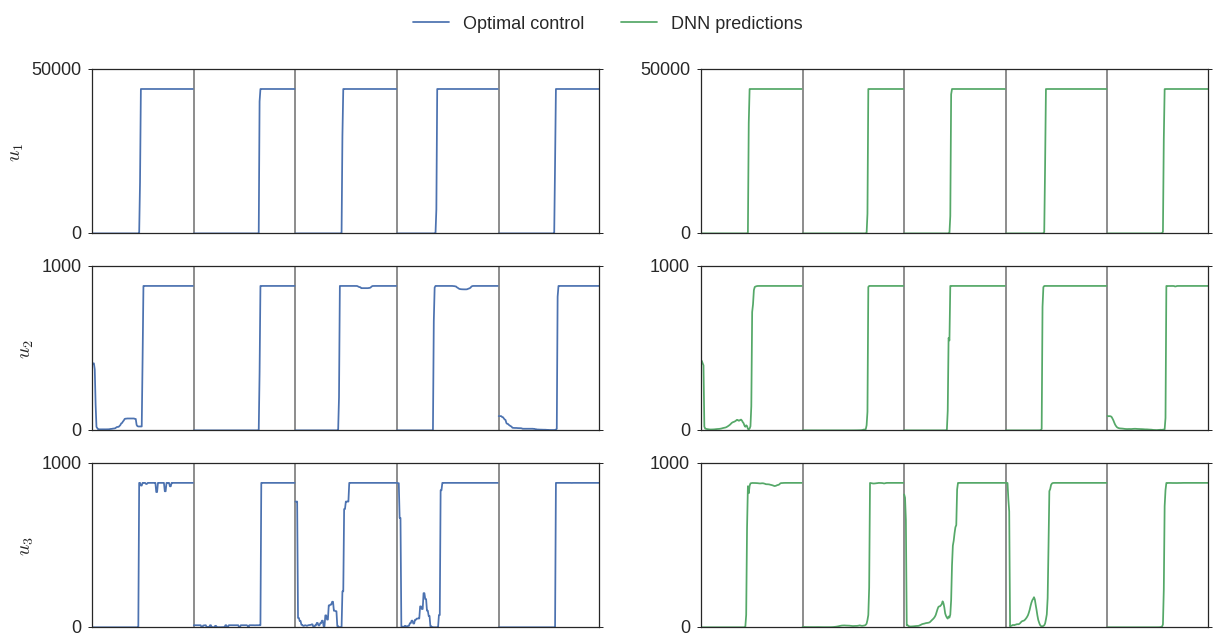

In [76]:
plt.rcParams['figure.figsize'] = [20,10]

fig = plt.figure()

batch = 119*5
b = 1000
#for s, dset in enumerate(['train', 'test']):
for s, dset in enumerate(['test']):

    for i,(model,network) in enumerate(networks):

        plt.subplot(3, 2, i*2+0+1)
        u = np.zeros((batch,len(networks)))
        network_input = data['X_'+dset][b*batch:(b+1)*batch,:]
        #network_input = dc.nn.preprocess(model, network_input)
        ui = network['pred'](network_input) 
        u[:,i] = ui[:,0]

        u = dc.nn.postprocess(model, u)
        u_gt = data['Y_'+dset][b*batch:(b+1)*batch,:].copy()        
        u_gt = dc.nn.postprocess(model, u_gt)   
        
        for j in range(5):
            label_1, = plt.plot(np.arange(119)+j*119,u_gt[j*119:(j+1)*119,i], c=sns.color_palette()[0])
        #label_1, = plt.plot(u_gt[:,i], c=sns.color_palette()[1])
        
        plt.locator_params(axis='y', nbins=1)
        
        plt.gca().get_xaxis().set_ticks([])
        plt.ylabel(r'$' + 'u_'+str(i+1)+'$')
        ylims = plt.ylim()
        plt.vlines([119*j for j in range(5)], plt.ylim()[0], plt.ylim()[1],color='gray')

        plt.subplot(3, 2, i*2+1+1)        
#        label_2, = plt.plot(u[:,i])
        for j in range(5):
            label_2, = plt.plot(np.arange(119)+j*119, u[j*119:(j+1)*119,i], c=sns.color_palette()[1])
        
        plt.locator_params(axis='y', nbins=1)
        plt.gca().get_xaxis().set_ticks([])
        plt.ylim(ylims)
        
        plt.vlines([119*j for j in range(5)], plt.ylim()[0], plt.ylim()[1],color='gray')

                
plt.figlegend([label_1,label_2], ['Optimal control', 'DNN predictions'], loc='upper center', ncol=2)


In [77]:
fig.savefig('imgs/three_thrusters_optimal_nn_driven_control_multiple.png', bbox_inches='tight')
fig.savefig('imgs/three_thrusters_optimal_nn_driven_control_multiple.pdf', bbox_inches='tight')


In [44]:
col_names = ['t', 'm', 'x', 'vx', 'z', 'vz', 'theta', 'vtheta', 'T', 'Tl', 'Tr']

trajs = dc.data.load_trajectories('../data/main_thrusters/', col_names = col_names, n=100)

Loading trajectories: 100%|██████████| 100/100 [00:00<00:00, 311.41it/s]


In [45]:
training_cols = [1,3,4,5,6,7]

In [46]:
from math import sin,cos

R = 3
g = 1.6229
g0 = 9.81
isp = 311

#state is [mass, x, vx, z, vz, theta, vtheta, thrust, thrust_left, thrust_right
#networks is [(model_thrust, network_thrust),
#             (model_thrust_left, network_thrust_left),
#             (model_thrust_right, network_thrust_right)]

def compute_control(state, networks):
    u = []
    for (model, network) in networks:
        network_input = state[[0,2,3,4,5,6]]
        network_input = dc.nn.preprocess(model, network_input)
        ui = network['pred'](network_input.reshape(1,-1))[0,0]            
        u.append(ui)
        
    u = np.asarray(u).reshape(1,-1)
    u = dc.nn.postprocess(model, u)[0]
    return u   

def dy(state, t, networks, compute_control):
    
    m = state[0]
    vx = state[2]
    z = state[3]
    vz = state[4]
    theta = state[5]
    vtheta = state[6]
        
    u = compute_control(state,networks)
    
    d_m = -(sum(u)) / (isp*g0);
    d_x = vx
    d_vx = sum(u) * sin(theta) / m
    d_z = vz
    d_vz = sum(u) * cos(theta) / m - g  
    d_vtheta = (u[1] - u[2]) / m / R;
    d_theta = vtheta
    ds = np.array([d_m, d_x, d_vx, d_z, d_vz, d_theta, d_vtheta])               
    return ds



In [47]:
show = 58
show_vars = [0,1,2]
units = ['N', 'N', 'N']


sns.set(font_scale=1.8)

sns.set_style("whitegrid")
#sns.set_context("talk")
sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})
plt.rcParams['figure.figsize'] = (6, len(show_vars)*5)


In [95]:
def final_check(state):
    if state[3] < 0:
        return 'crash'    
    if (state[3] - 10)<10 and abs(state[4]) < 1 and abs(state[2]) < 1:
        return 'done'
    return None

KeyboardInterrupt: 

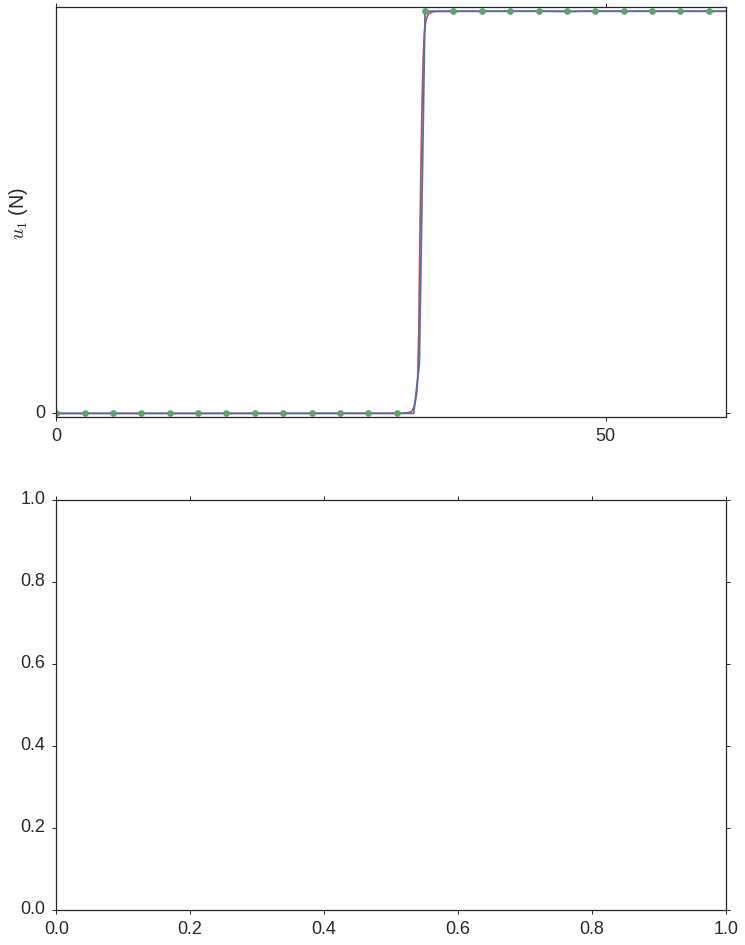

In [96]:
fig = plt.figure()

for n in show_vars:
    
    plt.subplot(len(show_vars),1,n+1)
    
    
    control_vars = ['T', 'Tl', 'Tr']

    (model, network) = networks[n]

    input_data = trajs[show].values[:,training_cols]
    t = trajs[show].values[:,0]
    gt_u = trajs[show].values[:,-3+n]

    input_data = dc.nn.preprocess(model_th, input_data)

    initial_pos = trajs[show].values[0,1:-3]
    
    nn_traj = dc.integrate.integrate_landing(dy, networks, compute_control, initial_pos, final_check,  stop_if_crash=False, stop_if_done=True, col_names=col_names, max_time =100, dt=0.1, )[0]

    (model, network) = networks[n]
    u = np.zeros((len(input_data),len(networks)))
    ui = network['pred'](input_data) 
    u[:,n] = ui[:,0]
    u = dc.nn.postprocess(model, u)

    label1, = plt.plot(t,gt_u, zorder =0)
    scatter_n = 20
    scatter_selected = list(range(0,len(t), int(len(t)/scatter_n)))
    label2  = plt.scatter(t[scatter_selected], u[scatter_selected,n],  c=sns.color_palette()[1], zorder=2, edgecolors='gray', s=40)
    label3, = plt.plot(nn_traj['t'],nn_traj[control_vars[n]], c=sns.color_palette()[2], zorder =-2)      

    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=3)
    plt.xlim((0,t[-1]))
    plt.ylim((min(gt_u)-max(gt_u+500)/100,max(gt_u)+max(gt_u+500)/100))
    
    xlabel = 't (s)' if n == show_vars[-1] else ''

    sns.axlabel(xlabel, r'$u_'+str(n+1)+'$ (' + units[n] +') ')
    
plt.figlegend([label1,label2,label3], ['Optimal trajectory', 'DNN predictions', 'Integration'], loc='upper center')

    #fig.savefig('imgs/optimal_preds_control.png', bbox_inches='tight')


In [ ]:
fig.savefig('imgs/three_thrusters_optimal_nn_driven_control.png', bbox_inches='tight')
fig.savefig('imgs/three_thrusters_optimal_nn_driven_control.pdf', bbox_inches='tight')


In [ ]:
trajs[show].columns = ['t', r'$m$', r'$x$', r'$v_x$', r'$z$', r'$v_z$', r'$\theta$', r'$v_\theta$', r'$u_1$',r'$u_2$',r'$u_3$' ]

In [84]:
nn_traj.columns = ['t', r'$m$', r'$x$', r'$v_x$', r'$z$', r'$v_z$', r'$\theta$', r'$v_\theta$', r'$u_1$',r'$u_2$',r'$u_3$' ]

In [85]:
import importlib
importlib.reload(dc.vis)

<module 'deep_control.vis' from '../deep_control/vis.py'>

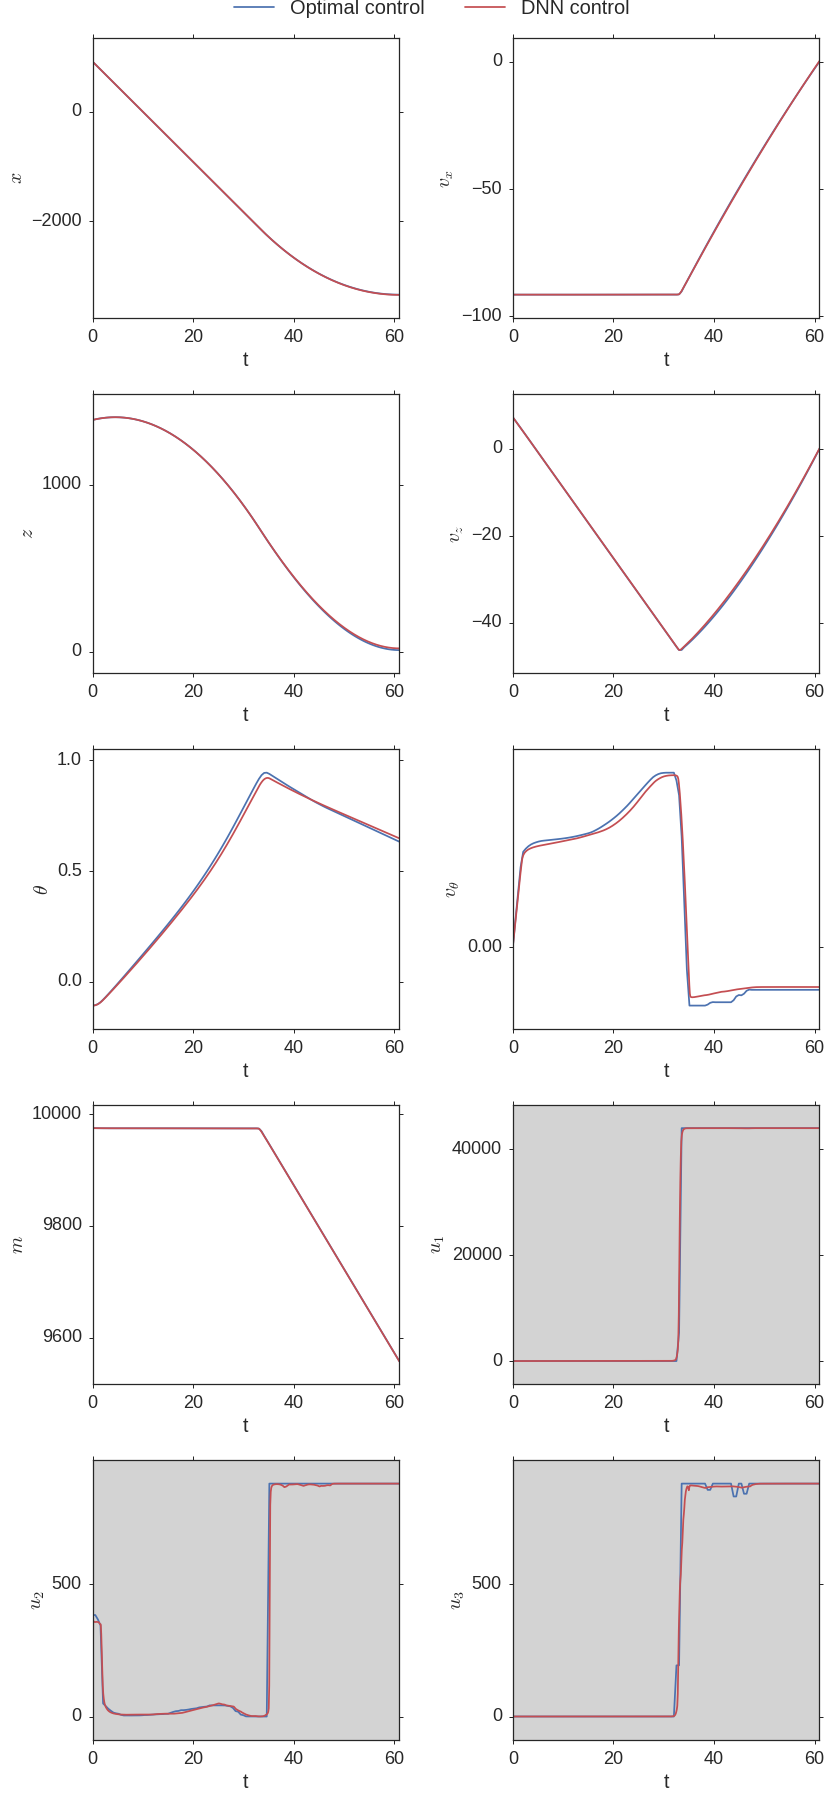

In [86]:
fig = dc.vis.compare_control(trajs[show], nn_traj, 3, 2, order = [1,2,3,4,5,6,0,7,8,9])

In [87]:
fig.savefig('imgs/three_thrusters_optimal_nn_driven_control_allvars.png', bbox_inches='tight')
fig.savefig('imgs/three_thrusters_optimal_nn_driven_control_allvars.pdf', bbox_inches='tight')


In [56]:

sns.set(font_scale=1.8)

sns.set_style("whitegrid")
#sns.set_context("talk")
sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})


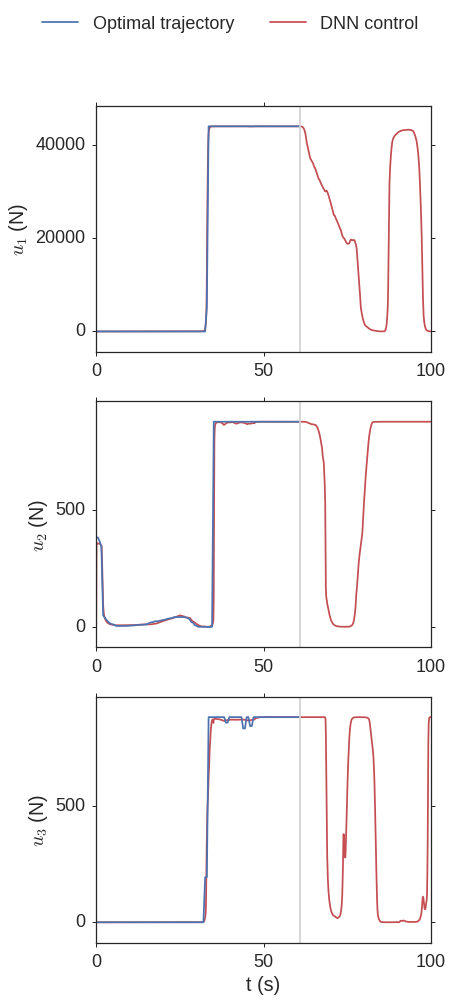

In [57]:
show_vars = [0,1,2]

plt.rcParams['figure.figsize'] = (6, len(show_vars)*5)
show = 58
fig = plt.figure()
for n in show_vars:
    
    plt.subplot(len(show_vars),1,n+1)
    
    control_vars = ['T', 'Tl', 'Tr']

    (model, network) = networks[n]

    input_data = trajs[show].values[:,training_cols]
    t = trajs[show].values[:,0]
    gt_u = trajs[show].values[:,-3+n]

    initial_pos = trajs[show].values[0,1:-3]
    nn_traj = dc.integrate.integrate_landing(dy, networks, compute_control, initial_pos, final_check,  stop_if_crash=False, stop_if_done=False, col_names=col_names, max_time =100, dt=0.1, )[0]

    label1, = plt.plot(t,gt_u, zorder =0)
    label3, = plt.plot(nn_traj['t'],nn_traj[control_vars[n]], c=sns.color_palette()[2], zorder =-2)


    plt.locator_params(axis='y', nbins=4)
    plt.locator_params(axis='x', nbins=4)
    plt.xlim((0, nn_traj.values[-1, 0]))
    
    r = (max(gt_u)) - (min(gt_u))
    plt.ylim((min(gt_u)-0.1*r, max(gt_u)+0.1*r))    

    plt.vlines([t[-1]],plt.ylim()[0], plt.ylim()[1],color='lightgray')

    xlabel = 't (s)' if n == show_vars[-1] else ''

    sns.axlabel(xlabel, r'$u_'+str(n+1)+'$ (' + units[n] +') ')
    
plt.figlegend([label1,label3], ['Optimal trajectory',  'DNN control'], loc = 'upper center', ncol=2)

    #fig.savefig('imgs/optimal_preds_control.png', bbox_inches='tight')


In [58]:

fig.savefig('imgs/three_thrusters_optimal_nn_driven_control_nostop.png', bbox_inches='tight')

fig.savefig('imgs/three_thrusters_optimal_nn_driven_control_nostop.pdf', bbox_inches='tight')


In [ ]:
from math import pi

def evaluate_optimality(networks, params, n, col_names, dy, final_check):
    samples = []
    #while len(samples) < n:
    for i in tqdm(range(n)):
        found = False
        while not found:        
            conditions = {}
            initial_pos = []
            for key, value_range in params:
                conditions[key] = value_range[0] + (value_range[1]-value_range[0])*np.random.rand()
                initial_pos.append(conditions[key])

            traj = dc.data.get_trajectory('../SpaceAMPL/lander/hs/main_thrusters.mod', conditions, col_names=col_names)
            if traj is not None:
                (nn_traj,check) = dc.integrate.integrate_landing(dy, networks, compute_control, initial_pos, final_check,  stop_if_crash=True, stop_if_done=True, col_names=col_names, max_time =100, dt=0.01, )
                print(check)
                samples.append({'initial_pos':initial_pos, 'nn_traj' : nn_traj, 'opt_traj' : traj, 'check': check})
                found = True
    return samples
        

In [ ]:
def error_mass(opt, pred):
    goal =  pred['m'].iloc[0] - pred['m'].iloc[-1]
    optimal_goal =  opt['m'].iloc[0] - opt['m'].iloc[-1]
    error = (goal - optimal_goal)/optimal_goal
    return abs(error)

In [ ]:
def final_check(state):
    if state[3] < 0:
        return 'crash'    
    if abs(state[3] -10) <10 and abs(state[4]) < 1 and abs(state[2]) < 1:
        return 'done'
    return None

In [91]:

params = [('m0', (8000,12000)),
          ('x0', (-1000,1000)),
          ('vx0', (-100,100)),
          ('z0', (500,2000)),          
          ('vz0', (-30,10)),
          ('theta0', (-np.pi/20,np.pi/20)),
          ('vtheta0', (0,0))]


samples = evaluate_optimality(networks, params, 100, col_names, dy, final_check)

  1%|          | 1/100 [00:27<44:46, 27.14s/it]

done


  2%|▏         | 2/100 [01:10<52:25, 32.10s/it]

crash


  3%|▎         | 3/100 [01:52<56:39, 35.05s/it]

None


  4%|▍         | 4/100 [02:35<59:40, 37.30s/it]

done


  5%|▌         | 5/100 [03:28<1:06:23, 41.93s/it]

None


  6%|▌         | 6/100 [03:52<57:29, 36.70s/it]  

done


  7%|▋         | 7/100 [04:51<1:07:27, 43.52s/it]

done


  8%|▊         | 8/100 [06:03<1:19:23, 51.78s/it]

done


  9%|▉         | 9/100 [06:27<1:06:03, 43.56s/it]

done


 10%|█         | 10/100 [07:19<1:08:57, 45.98s/it]

done


 11%|█         | 11/100 [07:38<56:13, 37.90s/it]  

done


 12%|█▏        | 12/100 [08:02<49:33, 33.79s/it]

done


 13%|█▎        | 13/100 [08:51<55:53, 38.55s/it]

done


 14%|█▍        | 14/100 [10:37<1:23:52, 58.52s/it]

done


 15%|█▌        | 15/100 [11:01<1:08:35, 48.41s/it]

done


 16%|█▌        | 16/100 [11:51<1:08:07, 48.66s/it]

done


 17%|█▋        | 17/100 [12:02<51:41, 37.37s/it]  

done


 18%|█▊        | 18/100 [12:48<54:56, 40.20s/it]

done


 19%|█▉        | 19/100 [13:24<52:23, 38.81s/it]

done


 20%|██        | 20/100 [14:13<55:48, 41.85s/it]

None


 21%|██        | 21/100 [14:36<47:46, 36.28s/it]

done


 22%|██▏       | 22/100 [15:00<42:05, 32.38s/it]

done


 23%|██▎       | 23/100 [15:36<43:10, 33.64s/it]

None


 24%|██▍       | 24/100 [16:36<52:28, 41.43s/it]

done


 25%|██▌       | 25/100 [17:20<52:53, 42.32s/it]

None


 26%|██▌       | 26/100 [17:52<48:13, 39.10s/it]

done


 27%|██▋       | 27/100 [18:37<50:00, 41.11s/it]

None


 28%|██▊       | 28/100 [18:56<41:13, 34.35s/it]

done


 29%|██▉       | 29/100 [19:14<34:59, 29.57s/it]

done


 30%|███       | 30/100 [19:43<34:16, 29.38s/it]

done


 31%|███       | 31/100 [20:30<39:45, 34.57s/it]

done


 32%|███▏      | 32/100 [21:05<39:24, 34.78s/it]

done


 33%|███▎      | 33/100 [21:31<35:37, 31.90s/it]

done


 34%|███▍      | 34/100 [22:05<35:50, 32.59s/it]

done


 35%|███▌      | 35/100 [22:25<31:14, 28.84s/it]

done


 36%|███▌      | 36/100 [23:40<45:44, 42.88s/it]

done


 37%|███▋      | 37/100 [24:00<37:42, 35.92s/it]

done


 38%|███▊      | 38/100 [24:48<40:48, 39.50s/it]

done


 39%|███▉      | 39/100 [25:14<36:04, 35.48s/it]

done


 40%|████      | 40/100 [26:05<40:06, 40.11s/it]

None


 41%|████      | 41/100 [26:42<38:30, 39.16s/it]

None


 42%|████▏     | 42/100 [27:07<33:45, 34.92s/it]

done


 43%|████▎     | 43/100 [27:34<30:57, 32.58s/it]

done


 44%|████▍     | 44/100 [28:14<32:20, 34.66s/it]

None


 45%|████▌     | 45/100 [28:32<27:20, 29.82s/it]

done


 46%|████▌     | 46/100 [28:53<24:31, 27.24s/it]

done


 47%|████▋     | 47/100 [30:21<40:05, 45.38s/it]

None


 48%|████▊     | 48/100 [31:12<40:42, 46.98s/it]

done


 49%|████▉     | 49/100 [32:45<51:37, 60.73s/it]

None


 50%|█████     | 50/100 [33:03<40:00, 48.01s/it]

done


 51%|█████     | 51/100 [33:19<31:17, 38.31s/it]

done


 52%|█████▏    | 52/100 [34:27<37:55, 47.41s/it]

None


 53%|█████▎    | 53/100 [35:32<41:09, 52.54s/it]

None


 54%|█████▍    | 54/100 [36:02<35:15, 45.98s/it]

done


 55%|█████▌    | 55/100 [36:23<28:40, 38.23s/it]

done


 56%|█████▌    | 56/100 [38:37<49:12, 67.09s/it]

None


 57%|█████▋    | 57/100 [39:22<43:25, 60.60s/it]

None


 58%|█████▊    | 58/100 [40:21<42:01, 60.04s/it]

None


 59%|█████▉    | 59/100 [42:03<49:37, 72.63s/it]

done


 60%|██████    | 60/100 [42:23<37:54, 56.86s/it]

done


 61%|██████    | 61/100 [43:02<33:26, 51.45s/it]

None


 62%|██████▏   | 62/100 [43:54<32:45, 51.74s/it]

done


 63%|██████▎   | 63/100 [44:44<31:33, 51.19s/it]

None


 64%|██████▍   | 64/100 [45:34<30:24, 50.69s/it]

None


 65%|██████▌   | 65/100 [45:46<22:46, 39.03s/it]

done


 66%|██████▌   | 66/100 [46:03<18:28, 32.60s/it]

done


 67%|██████▋   | 67/100 [46:23<15:49, 28.77s/it]

crash


 68%|██████▊   | 68/100 [47:06<17:36, 33.03s/it]

done


 69%|██████▉   | 69/100 [47:24<14:42, 28.48s/it]

done


 70%|███████   | 70/100 [48:37<20:54, 41.82s/it]

done


 71%|███████   | 71/100 [49:07<18:27, 38.19s/it]

done


 72%|███████▏  | 72/100 [49:26<15:07, 32.42s/it]

done


 73%|███████▎  | 73/100 [50:18<17:14, 38.31s/it]

None


 74%|███████▍  | 74/100 [50:36<14:00, 32.33s/it]

done


 75%|███████▌  | 75/100 [50:55<11:46, 28.28s/it]

done


 76%|███████▌  | 76/100 [51:13<10:04, 25.17s/it]

done


 77%|███████▋  | 77/100 [51:32<09:01, 23.52s/it]

done


 78%|███████▊  | 78/100 [52:10<10:10, 27.73s/it]

done


 79%|███████▉  | 79/100 [53:06<12:38, 36.12s/it]

None


 80%|████████  | 80/100 [53:24<10:16, 30.80s/it]

done


 81%|████████  | 81/100 [54:01<10:19, 32.61s/it]

crash


 82%|████████▏ | 82/100 [54:43<10:38, 35.45s/it]

crash


 83%|████████▎ | 83/100 [55:03<08:41, 30.66s/it]

done


 84%|████████▍ | 84/100 [55:49<09:25, 35.36s/it]

done


 85%|████████▌ | 85/100 [56:11<07:48, 31.26s/it]

done


 86%|████████▌ | 86/100 [56:29<06:25, 27.51s/it]

done


 87%|████████▋ | 87/100 [57:10<06:50, 31.56s/it]

done


 88%|████████▊ | 88/100 [57:29<05:31, 27.60s/it]

done


 89%|████████▉ | 89/100 [58:26<06:40, 36.38s/it]

None


 90%|█████████ | 90/100 [58:59<05:55, 35.59s/it]

done


 91%|█████████ | 91/100 [59:52<06:06, 40.77s/it]

None


 92%|█████████▏| 92/100 [1:01:02<06:35, 49.49s/it]

None


 93%|█████████▎| 93/100 [1:01:30<05:01, 43.03s/it]

done


 94%|█████████▍| 94/100 [1:01:55<03:45, 37.59s/it]

done


 95%|█████████▌| 95/100 [1:03:13<04:08, 49.68s/it]

done


 96%|█████████▌| 96/100 [1:04:04<03:21, 50.27s/it]

done


 97%|█████████▋| 97/100 [1:04:28<02:06, 42.32s/it]

done


 98%|█████████▊| 98/100 [1:04:58<01:17, 38.61s/it]

done


 99%|█████████▉| 99/100 [1:06:05<00:47, 47.22s/it]

None


crash


In [92]:
errors = []
crash = 0
lost = 0
for s in samples:
    
    if s['check'] == 'crash':
        crash +=1
    if s['check'] == None:
        lost +=1
    else:
        errors.append(error_mass(s['opt_traj'], s['nn_traj']))
                                  
print('Mass, relative error', np.mean(errors), ',computed from', len(errors), ' trajectories')
print('Crash rate: ', crash/len(samples)*100, '%')
print('Crash rate: ', lost/len(samples)*100, '%')

Mass, relative error 0.0756750634248 ,computed from 75  trajectories
Crash rate:  5.0 %
Crash rate:  25.0 %


In [1091]:
len(errors)

96

In [97]:

params = [('m0', (8000,12000)),
          ('x0', (-1000,1000)),
          ('vx0', (-100,100)),
          ('z0', (2000,3000)),          
          ('vz0', (-30,10)),
          ('theta0', (-np.pi/20,np.pi/20)),
          ('vtheta0', (0,0))]


samples2 = evaluate_optimality(networks, params, 100, col_names, dy, final_check)

  1%|          | 1/100 [01:01<1:42:00, 61.82s/it]

None


  2%|▏         | 2/100 [03:35<2:25:50, 89.29s/it]

None


  3%|▎         | 3/100 [04:25<2:05:29, 77.62s/it]

done


  4%|▍         | 4/100 [05:04<1:45:47, 66.12s/it]

None


  5%|▌         | 5/100 [05:26<1:23:34, 52.78s/it]

done


  6%|▌         | 6/100 [05:57<1:12:20, 46.17s/it]

done


  7%|▋         | 7/100 [07:10<1:24:03, 54.23s/it]

crash


  8%|▊         | 8/100 [07:50<1:16:41, 50.02s/it]

None


  9%|▉         | 9/100 [08:12<1:03:05, 41.60s/it]

done


 10%|█         | 10/100 [09:31<1:19:05, 52.73s/it]

None


 11%|█         | 11/100 [09:52<1:04:03, 43.19s/it]

crash


 12%|█▏        | 12/100 [11:39<1:31:28, 62.37s/it]

done


 13%|█▎        | 13/100 [12:59<1:38:15, 67.77s/it]

done


 14%|█▍        | 14/100 [13:29<1:20:55, 56.46s/it]

crash


 15%|█▌        | 15/100 [14:15<1:15:21, 53.19s/it]

crash


 16%|█▌        | 16/100 [15:15<1:17:37, 55.44s/it]

done


 17%|█▋        | 17/100 [15:46<1:06:17, 47.93s/it]

done


 18%|█▊        | 18/100 [16:59<1:15:43, 55.40s/it]

None


 19%|█▉        | 19/100 [17:38<1:08:06, 50.46s/it]

done


 20%|██        | 20/100 [18:14<1:01:40, 46.25s/it]

crash


 21%|██        | 21/100 [19:12<1:05:23, 49.67s/it]

done


 22%|██▏       | 22/100 [19:42<57:06, 43.93s/it]  

done


 23%|██▎       | 23/100 [20:49<1:05:04, 50.71s/it]

done


 24%|██▍       | 24/100 [21:49<1:07:50, 53.56s/it]

crash


 25%|██▌       | 25/100 [22:27<1:01:01, 48.81s/it]

None


 26%|██▌       | 26/100 [22:52<51:27, 41.73s/it]  

done


 27%|██▋       | 27/100 [23:52<57:29, 47.26s/it]

None


 28%|██▊       | 28/100 [24:16<48:17, 40.24s/it]

done


 29%|██▉       | 29/100 [24:47<44:27, 37.58s/it]

done


 30%|███       | 30/100 [25:34<47:05, 40.36s/it]

done


 31%|███       | 31/100 [26:00<41:32, 36.12s/it]

crash


 32%|███▏      | 32/100 [26:30<38:34, 34.03s/it]

crash


 33%|███▎      | 33/100 [27:53<54:37, 48.92s/it]

crash


 34%|███▍      | 34/100 [28:49<56:01, 50.93s/it]

done


 35%|███▌      | 35/100 [29:10<45:23, 41.90s/it]

done


 36%|███▌      | 36/100 [30:51<1:03:41, 59.71s/it]

done


 37%|███▋      | 37/100 [31:37<58:20, 55.56s/it]  

done


 38%|███▊      | 38/100 [32:20<53:37, 51.89s/it]

None


 39%|███▉      | 39/100 [33:21<55:32, 54.63s/it]

done


 40%|████      | 40/100 [33:55<48:26, 48.44s/it]

done


 41%|████      | 41/100 [34:24<41:50, 42.56s/it]

crash


 42%|████▏     | 42/100 [35:22<45:31, 47.09s/it]

done


 43%|████▎     | 43/100 [36:21<48:18, 50.85s/it]

crash


 44%|████▍     | 44/100 [36:44<39:41, 42.54s/it]

done


 45%|████▌     | 45/100 [37:59<47:47, 52.13s/it]

done


 46%|████▌     | 46/100 [38:23<39:25, 43.81s/it]

done


 47%|████▋     | 47/100 [38:52<34:41, 39.27s/it]

done


 48%|████▊     | 48/100 [39:47<38:03, 43.92s/it]

None


 49%|████▉     | 49/100 [40:43<40:32, 47.70s/it]

None


 50%|█████     | 50/100 [41:42<42:23, 50.88s/it]

None


 51%|█████     | 51/100 [42:34<42:03, 51.51s/it]

done


 52%|█████▏    | 52/100 [43:01<35:14, 44.06s/it]

done


 53%|█████▎    | 53/100 [44:47<49:07, 62.71s/it]

crash


 54%|█████▍    | 54/100 [45:14<39:44, 51.84s/it]

crash


 55%|█████▌    | 55/100 [45:50<35:23, 47.18s/it]

done


 56%|█████▌    | 56/100 [46:49<37:09, 50.68s/it]

done


 57%|█████▋    | 57/100 [48:25<46:02, 64.24s/it]

crash


 58%|█████▊    | 58/100 [50:03<52:07, 74.47s/it]

None


 59%|█████▉    | 59/100 [52:12<1:02:06, 90.89s/it]

None


 60%|██████    | 60/100 [53:51<1:02:12, 93.30s/it]

None


 61%|██████    | 61/100 [54:22<48:27, 74.55s/it]  

done


 62%|██████▏   | 62/100 [56:16<54:35, 86.20s/it]

None


 63%|██████▎   | 63/100 [57:20<49:08, 79.70s/it]

None


 64%|██████▍   | 64/100 [58:30<45:58, 76.63s/it]

done


 65%|██████▌   | 65/100 [59:32<42:08, 72.23s/it]

done


 66%|██████▌   | 66/100 [1:00:34<39:21, 69.45s/it]

done


 67%|██████▋   | 67/100 [1:01:23<34:43, 63.14s/it]

crash


 68%|██████▊   | 68/100 [1:02:03<30:00, 56.25s/it]

done


 69%|██████▉   | 69/100 [1:03:05<30:00, 58.10s/it]

None


 70%|███████   | 70/100 [1:03:30<23:57, 47.93s/it]

done


 71%|███████   | 71/100 [1:04:31<25:05, 51.90s/it]

done


 72%|███████▏  | 72/100 [1:04:58<20:41, 44.35s/it]

crash


 73%|███████▎  | 73/100 [1:05:42<19:54, 44.25s/it]

crash


 74%|███████▍  | 74/100 [1:06:21<18:31, 42.73s/it]

None


 75%|███████▌  | 75/100 [1:09:07<33:12, 79.68s/it]

done


 76%|███████▌  | 76/100 [1:10:00<28:45, 71.89s/it]

crash


 77%|███████▋  | 77/100 [1:10:27<22:23, 58.43s/it]

crash


 78%|███████▊  | 78/100 [1:11:49<23:56, 65.29s/it]

done


 79%|███████▉  | 79/100 [1:12:30<20:16, 57.93s/it]

None


 80%|████████  | 80/100 [1:12:59<16:28, 49.45s/it]

done


 81%|████████  | 81/100 [1:13:29<13:46, 43.48s/it]

done


 82%|████████▏ | 82/100 [1:14:19<13:40, 45.57s/it]

None


 83%|████████▎ | 83/100 [1:15:55<17:11, 60.65s/it]

done


 84%|████████▍ | 84/100 [1:17:26<18:37, 69.85s/it]

done


 85%|████████▌ | 85/100 [1:17:48<13:52, 55.50s/it]

crash


 86%|████████▌ | 86/100 [1:19:18<15:19, 65.65s/it]

done


 87%|████████▋ | 87/100 [1:21:00<16:37, 76.77s/it]

crash


 88%|████████▊ | 88/100 [1:21:44<13:21, 66.80s/it]

None


 89%|████████▉ | 89/100 [1:22:45<11:55, 65.00s/it]

done


 90%|█████████ | 90/100 [1:23:17<09:12, 55.21s/it]

done


 91%|█████████ | 91/100 [1:23:50<07:16, 48.48s/it]

crash


 92%|█████████▏| 92/100 [1:24:16<05:34, 41.79s/it]

done


 93%|█████████▎| 93/100 [1:25:18<05:34, 47.75s/it]

done


 94%|█████████▍| 94/100 [1:26:08<04:50, 48.37s/it]

done


 95%|█████████▌| 95/100 [1:26:34<03:28, 41.68s/it]

done


 96%|█████████▌| 96/100 [1:27:08<02:37, 39.40s/it]

done


 97%|█████████▋| 97/100 [1:27:46<01:56, 38.98s/it]

None


 98%|█████████▊| 98/100 [1:28:33<01:22, 41.41s/it]

done


 99%|█████████▉| 99/100 [1:29:07<00:39, 39.23s/it]

done


None


In [101]:
errors = []
crash = 0
lost = 0
for s in samples2:
    
    if s['check'] == 'crash':
        crash +=1
    if s['check'] == None:
        lost +=1
    else:
        errors.append(error_mass(s['opt_traj'], s['nn_traj']))
                                  
print('Mass, relative error', np.mean(errors), ',computed from', len(errors), ' trajectories')
print('Crash rate: ', crash/len(samples2)*100, '%')
print('Crash rate: ', lost/len(samples2)*100, '%')

Mass, relative error 0.0277206124163 ,computed from 76  trajectories
Crash rate:  22.0 %
Crash rate:  24.0 %


In [ ]:

params = [('m0', (8000,12000)),
          ('x0', (-1000,1000)),
          ('vx0', (-100,100)),
          ('z0', (3000,4000)),          
          ('vz0', (-30,10)),
          ('theta0', (-np.pi/20,np.pi/20)),
          ('vtheta0', (0,0))]


samples3 = evaluate_optimality(networks, params, 100, col_names, dy, final_check)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
errors = []
crash = 0
lost = 0
for s in samples3:
    
    if s['check'] == 'crash':
        crash +=1
    if s['check'] == None:
        lost +=1
    else:
        errors.append(error_mass(s['opt_traj'], s['nn_traj']))
                                  
print('Mass, relative error', np.mean(errors), ',computed from', len(errors), ' trajectories')
print('Crash rate: ', crash/len(samples3)*100, '%')
print('Crash rate: ', lost/len(samples3)*100, '%')

In [465]:
x = np.asarray([-10 ,-10,  10,10,       15,  5,   -5,  -5,   15,   -15,  -15, 5,-10,10])*100
y= np.asarray([   10,    25,    25,  10,       20,   2,   30,  2,   30,     30, 20,30,5,5])*80

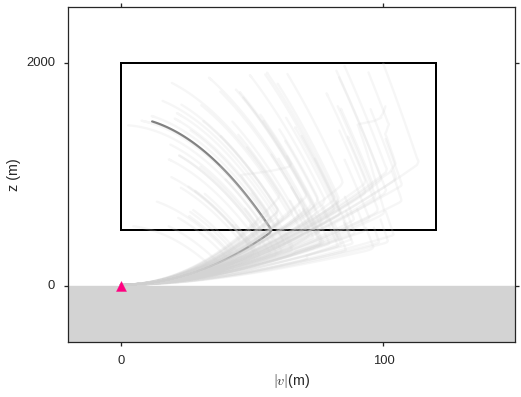

In [512]:
plt.rcParams['figure.figsize'] = (8,6)
from math import sqrt
fig = plt.figure()
ax = plt.axes(xlim=(-20,150), ylim=(-500, 2500))

ground = plt.Rectangle([-1500,-500],3000,500,color='lightgray')
training_area = plt.Rectangle([0,500],120,1500,facecolor='white',edgecolor='black',linewidth=2)
ax.add_patch(ground)
ax.add_patch(training_area)

goal = plt.scatter(0,0.1,s=100,zorder=10, color=[1,0,0.5], marker='^')    

gt_traj, = plt.plot(np.sqrt((trajs[0]['vz']**2+trajs[0]['vx']**2)), trajs[0]['z'] , color='gray', alpha = 1)
for t in trajs[1:500]:
            plt.plot(np.sqrt((t['vz']**2+t['vx']**2)), t['z'], color='lightgray', alpha = 0.2)

plt.ylabel('z (m)')
plt.xlabel(r'$|v|$' + '(m)')
    
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)
